In [1]:
import json
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import numpy as np
import pandas as pd
import feltorutilities as fp
import magneticfielddb as mag
import simplesimdb as simplesim
import xarray as xr
import xfeltor
import time

plt.rcParams.update({'font.size': 14})
# pd.set_option('display.float_format', lambda x: '%.2e' % x)

In [2]:
data = simplesim.Manager( directory="./resistivity-scan-data", filetype="nc")
diag = simplesim.Manager( executable="./feltordiag.sh", directory="resistivity-scan-diag", filetype="nc")

In [3]:
def create_merged_dataset( manager, params ) :
    datasetpaths = [manager.outfile(params,i) for i in range(manager.count(params))]
    return xfeltor.open_feltordataset( datasetpaths)


In [4]:
# This cell may take a minute ...
content = diag.table()
for pp in content : # modifying pp modifies content
    print( pp['physical']['resistivity'], pp['physical']['tau'])
    file = create_merged_dataset( diag, pp)
    pp['file'] = file
  

1e-06 1.0
0.0001 0.0
0.0001 1.0
3e-05 0.0
3e-06 0.0
1e-05 1.0
0.0003 1.0
1e-05 0.0
0.0003 0.0
3e-05 1.0
1e-06 0.0
3e-06 1.0


In [5]:
da0 = Dataset( diag.files()[0]['outputfile']) # All Sims use the same magnetic field
for pp in content : # modifying pp modifies content
    print( pp['physical']['resistivity'], pp['physical']['tau'])
    num = {"R_0" : pp["magnetic_field"]['params']["R_0"], **pp["physical"]}
    fp.numerical2physical( num, pp['physical'])
    
    pp['rho'] = da0['rho'][:]
    pp['rho_t'] = da0['rho_t'][:]
    pp['rho_p'] = da0['rho_p'][:]
    pp['lcfs'] = np.argmax( pp['rho_t'][np.where( pp['rho_t'] < 1)])
    pp['area'] = da0['psi_area'][:]
    pp['volume'] = da0['psi_vol'][:]

1e-06 1.0
Invert for given numerical parameters
0.0001 0.0
Invert for given numerical parameters
0.0001 1.0
Invert for given numerical parameters
3e-05 0.0
Invert for given numerical parameters
3e-06 0.0
Invert for given numerical parameters
1e-05 1.0
Invert for given numerical parameters
0.0003 1.0
Invert for given numerical parameters
1e-05 0.0
Invert for given numerical parameters
0.0003 0.0
Invert for given numerical parameters
3e-05 1.0
Invert for given numerical parameters
1e-06 0.0
Invert for given numerical parameters
3e-06 1.0
Invert for given numerical parameters


In [6]:
# sort parameters
content = sorted(content, key=lambda pp: (pp['physical']['resistivity'], pp['physical']['tau']))
for pp in content :
    print( pp['physical']['resistivity'], pp['physical']['tau'])


1e-06 0.0
1e-06 1.0
3e-06 0.0
3e-06 1.0
1e-05 0.0
1e-05 1.0
3e-05 0.0
3e-05 1.0
0.0001 0.0
0.0001 1.0
0.0003 0.0
0.0003 1.0


In [7]:
# drop last index in one sim because it crashed
# USE ONLY ONCE
for pp in content :
    if pp['physical']['resistivity'] == 3e-4 and  pp['physical']['tau'] == 0 :
        pp['file'] = pp['file'].drop_isel(time = [-1])
#         print( pp['physical']['resistivity'], pp['physical']['tau'])
#         print( pp['file'])

In [8]:
min_idx_dict = {
    0 : {1e-6: 250, 1e-4 : 200 , 1e-5 : 275, 3e-6: 250, 3e-5 : 500, 3e-4: 150},
    1 : {1e-6: 250, 1e-4 : 200 , 1e-5 : 275, 3e-6: 250, 3e-5 : 500, 3e-4: 150}          
} # in cs/R0

In [9]:
# http://vrl.cs.brown.edu/color
colors =[ 
# "#256676", "#b4dbe7", "#1e39ae", "#aad46f", "#940393",
#  "#43e26d", "#d60724", "#3eeaef", "#0b5313", "#cd6ad8" #change color 6,which is red
# "#32964d", "#ad0599", "#39f27a", "#323d96", "#2fddce",
#  "#0a4f4e", "#a1d832", "#8b6fed", "#38b5fc", "#752e4f"
'C0','C1','C2','C4','C5','C6','C7','C8','C9'    
]

In [10]:
# to_plot = dict()
# {
#     "tau" : [], # taus
#     "res": {0:[],1:[]} # resistivities for taus
#     "fields" : [ # list of dicts
#     {
#         "color": 0,
#         "label" : r"$\partial_t n_e$",
#         "vals": {0:{res: [], ...},1:{...}}, # time series for tau = 0 and tau = 1 and various resistivities
#     }
#     ]
# }
def plot_relative( to_plot, ax, tau, style):  
    """Compute mean and error of several terms described in to_plot as a function of resistivity
    on given axis ax, for given tau
    """
    resistivities = np.array(sorted(to_plot["res"][tau]))
    size = resistivities.size
    mean=dict()
    std = dict()
    
    for field in to_plot["fields"]:
        mean[field["label"]]=np.zeros(size)
        std[field["label"]]=np.zeros(size)
        for i in np.arange(0,size,1):  
            min_idx = min_idx_dict[tau][resistivities[i]]
            mean[field["label"]][i] = field["vals"][tau][resistivities[i]][min_idx:].mean()
            std[field["label"]][i] = field["vals"][tau][resistivities[i]][min_idx:].std()
#         print( "Averages ", field["label"], " is ", mean[field["label"]])
    error = list()
    mean_error = np.zeros(size)
    std_error = np.zeros(size)
    for i in np.arange(0,size,1):   
        min_idx = min_idx_dict[tau][resistivities[i]]
        error.append(np.zeros( len(to_plot["times"][tau][resistivities[i]][min_idx:])))
        for field in to_plot["fields"]:
            error[i] = error[i] + field["vals"][tau][resistivities[i]][min_idx:]
        mean_error[i] = error[i].mean()
        std_error[i] = error[i].std()

    summe = np.abs(mean_error)
    for field in to_plot["fields"]:
        summe = summe + np.abs(mean[field["label"]])
    if style == "log":
        for field in to_plot["fields"]:
            if(mean[field["label"]].mean() != 0):
                ax.plot( resistivities, np.abs(mean[field["label"]])/summe,
            #                  yerr=delta_err[tau],capsize=4
                    marker='x', ls='-',label=field["label"]
                        , color = colors[field["color"]]
                       )
                ax.fill_between(resistivities, np.abs(mean[field["label"]])/summe,
                                (np.abs(mean[field["label"]])+std[field["label"]])/summe,
                                color = colors[field["color"]], alpha=0.1)
        ax.plot( resistivities, np.abs(mean_error)/summe,
                marker='x', ls='--',label="Error",  color = "r"
               )
        ax.fill_between(resistivities, np.abs(mean_error)/summe,
                (np.abs(mean_error)+std_error)/summe,
                color ="r", alpha=0.1)
        ax.set_yscale('log')
    elif style == 'linear':

        for field in to_plot["fields"]:
            if(mean[field["label"]].mean() != 0):
                ax.plot( resistivities, mean[field["label"]]/summe,
            #                  yerr=delta_err[tau],capsize=4
                    marker='x', ls='-',label=field["label"]
                        , color = colors[field["color"]]
                       )
                ax.fill_between(resistivities, (mean[field["label"]]-std[field["label"]])/summe,
                                (mean[field["label"]]+std[field["label"]])/summe,
                                color = colors[field["color"]],
                        alpha=0.2)
        ax.plot( resistivities, mean_error/summe,
                marker='x', ls='--',label="Error",  color = "r"  )
        ax.fill_between(resistivities, (mean_error-std_error)/summe, (mean_error+std_error)/summe,
                        color='r', alpha=0.1)
        low, high = ax.get_ylim()
        # find the new limits
        bound = max(abs(low), abs(high))
        # set new limits
        ax.set_ylim(-bound, bound)  
            
            
    ax.set_xlabel(r'$\eta$')
    ax.set_ylabel('relative importance')
    ax.set_xscale('log')    

In [11]:
def plot_series( to_plot, ax, tau, res, start_idx=1):   
    """Plot several terms described in to_plot as a function of time on given axis
    for given tau and resistivity
    """
    mean=dict()
    std = dict()
    min_idx = min_idx_dict[tau][res]
    for field in to_plot["fields"]:
        mean[field["label"]] = field["vals"][tau][res][min_idx:].mean()
        std[field["label"]]  = field["vals"][tau][res][min_idx:].std()
#         print( "Averages ", field["label"], " is ", mean[field["label"]])
    error = np.zeros( len(to_plot["times"][tau][res]))
    for field in to_plot["fields"]:
        error = error + field["vals"][tau][res]
    mean_error = error[min_idx:].mean()
    std_error = error[min_idx:].std()
    print( "Mean error is ", mean_error, " std error is ", std_error)

    for field in to_plot["fields"]:
        ax.plot( to_plot["times"][tau][res][start_idx:], field["vals"][tau][res][start_idx:],
    #                  yerr=delta_err[tau],capsize=4
            ls='-',label=field["label"]
                , color = colors[field["color"]]
               )
#         ax.hlines(mean[field['label']], to_plot["times"][tau][res][min_idx],
#                   to_plot["times"][tau][res][-1], color=colors[field["color"]])
        ax.fill_between( to_plot["times"][tau][res][min_idx:],
                        (mean[field['label']]-std[field['label']]),
                        (mean[field['label']]+std[field['label']]),
                        color=colors[field["color"]], alpha=0.2)
    
    ax.plot( to_plot["times"][tau][res][start_idx:], error[start_idx:],
            ls='--',label="Error",  color = "r"
           )
#     ax.hlines(mean_error, to_plot["times"][tau][res][min_idx],
#               to_plot["times"][tau][res][-1], color='r')
    ax.fill_between( to_plot["times"][tau][res][min_idx:],
                    (mean_error-std_error), (mean_error+std_error),
                    color='red', alpha=0.2)
    ax.set_xlabel(r'$t$ / $\Omega_0^{-1}$')
    ax.set_ylabel(r'$\int_0^{v(1)} \langle t_i(R,Z,\varphi,t)\rangle dv$')
    # get y-axis limits of the plot
    low, high = ax.get_ylim()
    # find the new limits
    bound = max(abs(low), abs(high))
    # set new limits
    ax.set_ylim(-bound, bound)

In [12]:
def make_to_plot( to_plot):
    """Fill in values in the to_plot dictionary"""
    for pp in content :
        da = pp['file']
        time = np.asarray(da['time'][:])
        deltat = np.diff(np.append(time, 2*time[-1] -time[-2]))
        tau = pp["physical"]["tau"]
        res = pp["physical"]["resistivity"]
        to_plot["res"][tau].append(res)
        to_plot["times"][tau][res] = time
        to_plot["params"][tau][res] = pp 
        for field in to_plot["fields"]:
            series = np.zeros(len(time))
            for (name,sign) in zip(field["names"],field["signs"]):
                if "idx" in field.keys():
                    series = series + np.asarray(da[name][:,field["idx"]])*sign
                else:
                    series = series + np.asarray(da[name][:])*sign
            if field["derive"]:
                series = np.diff(np.append(np.zeros(1),series, axis=0))/deltat
            else:
                series = series/deltat
            field["vals"][tau][res] = series

In [13]:
### THE TERMS IN THE MASS CONSERVATION
to_plot = {
    "tau" : [0,1], # taus
    "res": {0:[],1:[]}, # resistivities for taus
    "times": {0:dict(),1:dict()},
    "params" : {0:dict(),1:dict()}, # a copy of all parameters
    "fields" : [ # list of dicts
    {
        "names" : ["electrons_ifs_lcfs"], "derive" : True, "signs" : [+1],
#         "names" : ["ions_ifs_lcfs"], "derive" : True, "signs" : [+1],
        "color": 0,
        "label" : r"$\partial_t n_e$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['jvneE_tt_ifs_lcfs'], "derive" : False, "signs" : [+1],
#         "names" : ['jvniE_tt_ifs_lcfs'], "derive" : False, "signs" : [+1],
        "color": 1,
        "label" : r"$\nabla\cdot\vec{j_E}$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['jvneC_tt_ifs_lcfs'], "derive" : False, "signs" : [+1],
#         "names" : ['jvniC_tt_ifs_lcfs'], "derive" : False, "signs" : [+1],
        "color": 2,
        "label" : r"$\nabla\cdot\vec{j_C}$",
        "vals": {0:dict(),1:dict()},
    },
    {# small here but not in vorticity 
        "names" : ['jvneA_tt_ifs_lcfs'], "derive" : False, "signs" : [+1],
#         "names" : ['jvniA_tt_ifs_lcfs'], "derive" : False, "signs" : [+1],
        "color": 3,
        "label" :  r"$\nabla\cdot\vec{ j_A}$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['divjnepar_tt_ifs_lcfs'], "derive" : False, "signs" : [+1],
        "color": 4,
        "label" :  r"$\nabla \cdot \vec{ j_\parallel}$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['lneperp_tt_ifs_lcfs'], "derive" : False, "signs" : [-1],
#         "names" : ['lniperp_tt_ifs_lcfs'], "derive" : False, "signs" : [-1],
        # lniperp has a mistake in the feltordiag
        "color": 5,
        "label" :  r"$\Delta_\perp$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['lneparallel_tt_ifs_lcfs'], "derive" : False, "signs" : [-1],
        "color": 6,
        "label" :  r"$\Delta_\parallel$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['sne_tt_ifs_lcfs'], "derive" : False, "signs" : [-1],
#         "names" : ['sni_tt_ifs_lcfs'], "derive" : False, "signs" : [-1],
        "color": 7,
        "label" :  r"$S_{n_e}$",
        "vals": {0:dict(),1:dict()},
    },
    ]
}
make_to_plot(to_plot)


### Volume Integrated Mass conservation
The density equations directly yield the particle conservation
\begin{align} \label{eq:mass_theorem}
  \frac{\partial}{\partial t} N
  + \nabla\cdot\vec{ j_{N}}
  =  \Lambda_{N}+S_{N}
\end{align}
The terms of the particle conservation thus read
\begin{align}
  N= & N,\\
  \vec j_{N} =& N\left(
  \vec u_\psi + \vec u_C + \vec u_{K} +U_\parallel\left(\hat b+{\vec b}_\perp\right)  \right)
\label{eq:particle_flux}\\
  %\nonumber\\
  %=& N \left(\frac{\bhat\times \vn\phi}{B}
  %+ \tau_e \frac{\bhat\times\vn n_e}{n_eB}
  %+ \mu_e u_{\parallel,e}^2\vec K_{\vn\times\bhat}
  %+ u_{\parallel,e}(\bhat + {\vec b}_\perp) \right), \\
  \Lambda_{N} =& \Lambda_N
\\
  S_{N} =&  S_{N}
\end{align}

#### Volume integration yields
\begin{align}
  \frac{\partial}{\partial t} \int \langle N  \rangle dv
  + \langle \vec{ j_{N}}\cdot \nabla v \rangle
  =  \int \langle\Lambda_{N}+S_{N}\rangle dv
\end{align}
where $\langle f\rangle$ denotes the flux surface average (i.e. integration over the toroidal and poloidal
angle using the volume form)
#### Time integration yields
\begin{align}
  \frac{1}{\Delta T}\int \langle N(t_1) - N(t_0)  \rangle dv 
  + \frac{1}{\Delta T}\int_{t_0}^{t_1}\langle \vec{ j_{N}}\cdot \nabla v \rangle dt
  =   \frac{1}{\Delta T}\int_{t_0}^{t_1}\int \langle\Lambda_{N}+S_{N}\rangle dv dt
\end{align}
or the scalar equation
\begin{align}
    \frac{M(t_1) - M(t_0)}{\Delta T} + \bar J_M = \bar \Lambda_M + \bar S_M
\end{align}
where $\bar f \equiv \int_{t_0}^{t_t} \langle f\rangle dt / \Delta T$

### Relative accuracy and importance of terms

The above equation can be written in the form $\sum_i T_i = 0$ with
\begin{align}
  T_i := \frac{1}{\Delta T} \int_{t_0}^{t_1} \int_\Omega t_i(R,Z,\varphi,t) dV dt = \frac{1}{\Delta T} \int_{t_0}^{t_1} \int_0^{v(1)} \langle t_i(R,Z,\varphi,t)\rangle dv dt
\end{align}
However, due to numerical and / or analytical approximations we usually have
\begin{align}
\sum_i T_i = E
\end{align}
where $E$ is an error that is small compared to the $T_i$. In order to quantify the error term and the importance of any individual term $T_i$ in general we now introduce the importance
\begin{align}
W_i  :=& \frac{T_i}{ |E| + \sum_i |T_i| } \\
W_E :=& \frac{E }{|E| + \sum_i |T_i| }
\end{align}

If the individual terms $T_i$ fluctuate with standard deviation $\varepsilon_{T_i}$ we approximate
the fluctuation of the importance 
\begin{align}
    \varepsilon_{W_i} :=& \frac{\varepsilon_{T_i}}{ |E| + \sum_i |T_i| } \\
    \varepsilon_{W_E} :=& \frac{\varepsilon_{E} }{|E| + \sum_i |T_i| }
\end{align}
    

In [14]:
def orderToString(x): 
    if np.isnan(x) : return 'n/a'
    return'%.2f'% x
def errorToString(x):
    return '%.2e' % x
def intToString(x):
    return '%02d' % x

In [15]:
# Create simulation times table
data=list()
columns=[r"$\eta$",'a', 'b', 'c', 'd']

for res in to_plot['res'][0]:
    line = list()
    line.append(res)
    for tau in to_plot['tau'] :
        timescale = fp.omega_0_inv(**to_plot["params"][tau][res]['physical'])*1e3 # in ms
        line.append( to_plot['times'][tau][res][-1])
        line.append( to_plot['times'][tau][res][-1]*timescale)
        
        #print( tau, res, to_plot['times'][tau][res][-1], to_plot['times'][tau][res][-1]*timescale)
    data.append(line)
df = pd.DataFrame( data, columns=columns) 
df_str = df
for header in ["$\eta$"] :  
    df_str[header] = df_str[header].apply( errorToString)
for header in ['a', 'c'] :  
    df_str[header] = df_str[header].apply( intToString)
for header in ['b', 'd'] :  
    df_str[header] = df_str[header].apply( orderToString)
df_str.set_index("$\eta$", inplace=True)

columns = [(r"$\tau=0$", r"$T_\mathrm{end}/\Omega_0^{-1}$"), (r"$\tau=0$",r"$T_\mathrm{end}/$ms"),
                (r"$\tau=1$", r"$T_\mathrm{end}/\Omega_0^{-1}$"), (r"$\tau=1$",r"$T_\mathrm{end}/$ms" )]
df.columns=pd.MultiIndex.from_tuples(columns)

filename = "endtimes.tex"
with open(filename, 'wb') as f:
    f.write(bytes(df_str.style.to_latex(
        column_format='rrrrr', hrules=True),'UTF-8'))
    

df_str


$\tau=0$                      \
         $T_\mathrm{end}/\Omega_0^{-1}$ $T_\mathrm{end}/$ms   
$\eta$                                                        
1.00e-06                          85000                1.39   
3.00e-06                          84200                1.82   
1.00e-05                          80700                2.35   
3.00e-05                          78700                3.02   
1.00e-04                         106700                5.53   
3.00e-04                          57300                3.91   

                               $\tau=1$                      
         $T_\mathrm{end}/\Omega_0^{-1}$ $T_\mathrm{end}/$ms  
$\eta$                                                       
1.00e-06                          99000                1.62  
3.00e-06                          89000                1.92  
1.00e-05                          82800                2.41  
3.00e-05                          85300                3.27  
1.00e-04                          94500                4.90  
3.00e-04                         104000                7.09

Mean error is  128.21753632398813  std error is  101.12780804913196


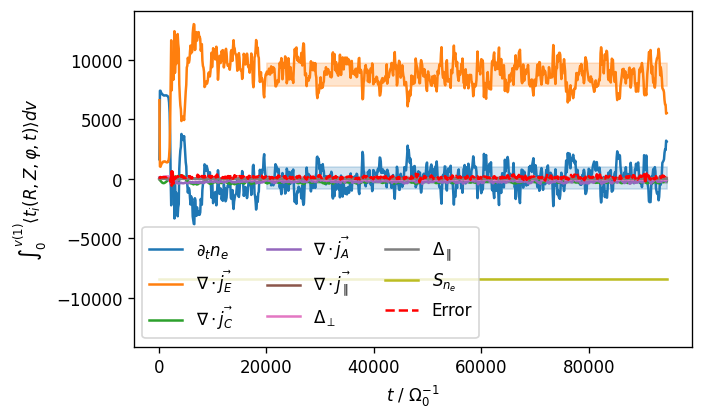

In [16]:
# for tau in [0,1]:
fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
tau = 1
res = 1e-4
plot_series(to_plot,ax,tau,res,start_idx=1)
#     ax.set_yscale("linear")


plt.legend(ncol=3,loc='lower left')
plt.savefig( 'ne-conservation-lcfs-'+str(tau)+str(res)+'.png',bbox_inches='tight')
plt.show()

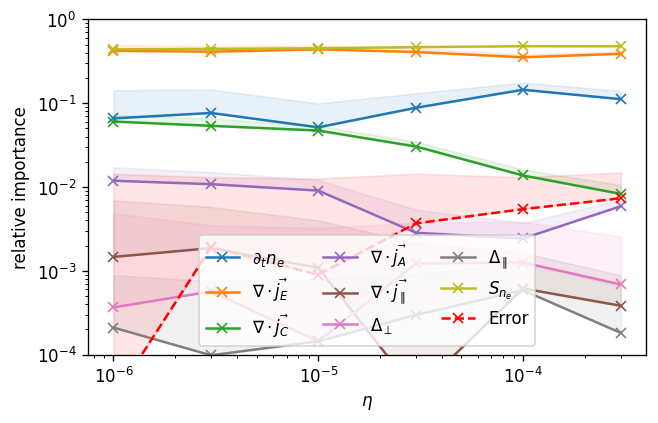

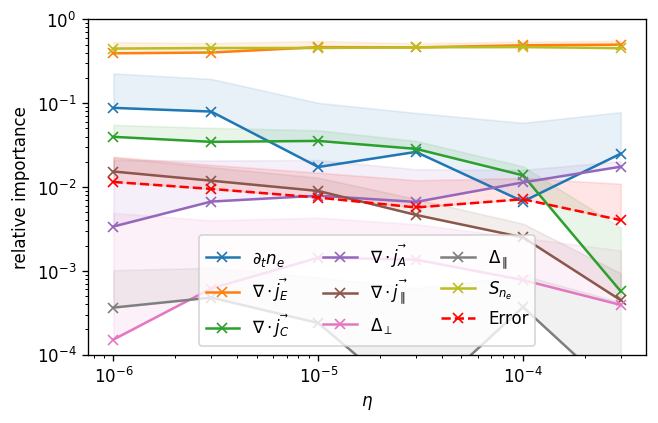

In [17]:
for tau in [0,1]:
    fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
    plot_relative(to_plot,ax,tau,'log')
#     ax.set_yscale("linear")
    plt.legend(ncol = 3, loc = 'lower center')
    plt.ylim([1e-4,1])
    plt.savefig( 'ne-importance-'+str(tau)+'.png',bbox_inches='tight')
    plt.show()

In [18]:
### THE TERMS IN THE ENERGY CONSERVATION
to_plot_energy = {
    "tau" : [0,1], # taus
    "res": {0:[],1:[]}, # resistivities for taus
    "times": {0:dict(),1:dict()},
    "params" : {0:dict(),1:dict()}, # a copy of all parameters
    "fields" : [ # list of dicts
    {
        "names" : ["ue2_ifs_lcfs","nelnne_ifs_lcfs","nilnni_ifs_lcfs",
                   "neue2_ifs_lcfs","niui2_ifs_lcfs","aperp2_ifs_lcfs"],
        "derive" : True, "signs" : [+1,1,1,1,1,1],
        "color": 0,
        "label" : r"$\partial_t E$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['jvee_tt_ifs_lcfs','jvei_tt_ifs_lcfs','jveea_tt_ifs_lcfs','jveia_tt_ifs_lcfs'],
        "derive" : False, "signs" : [+1,1,1,1],
        "color": 1,
        "label" : r"$\nabla\cdot\vec{j_E}$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['leeperp_tt_ifs_lcfs','leiperp_tt_ifs_lcfs'], "derive" : False, "signs" : [-1,-1],
        "color": 2,
        "label" :  r"$\Delta_\perp$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['leeparallel_tt_ifs_lcfs','leiparallel_tt_ifs_lcfs'], "derive" : False, "signs" : [-1,-1],
        "color": 6,
        "label" :  r"$\Delta_\parallel$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['see_tt_ifs_lcfs','sei_tt_ifs_lcfs'], "derive" : False, "signs" : [-1,-1],
        "color": 7,
        "label" :  r"$S_{E}$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['resistivity_tt_ifs_lcfs'], "derive" : False, "signs" : [-1],
        "color": 8,
        "label" :  r"$R$",
        "vals": {0:dict(),1:dict()},
    }
    ]
}
make_to_plot(to_plot_energy)


Mean error is  -1020.1142280844745  std error is  650.3477567379866


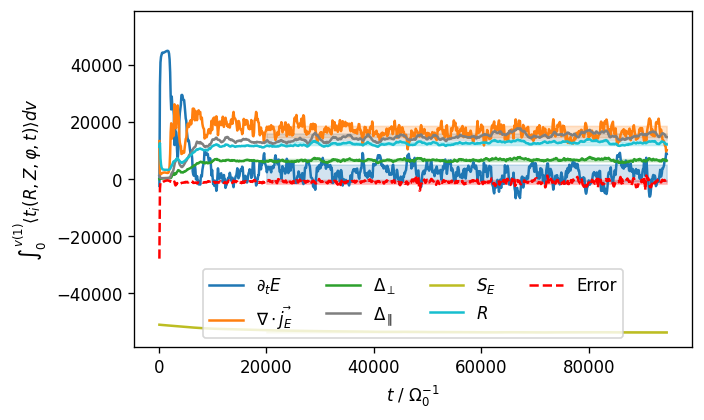

In [19]:
# for tau in [0,1]:
fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
tau = 1
res = 1e-4
plot_series(to_plot_energy,ax,tau,res,start_idx=1)

plt.legend(ncol=4,loc='lower center')
plt.savefig( 'energy-conservation-lcfs-'+str(tau)+str(res)+'.png',bbox_inches='tight')
plt.show()

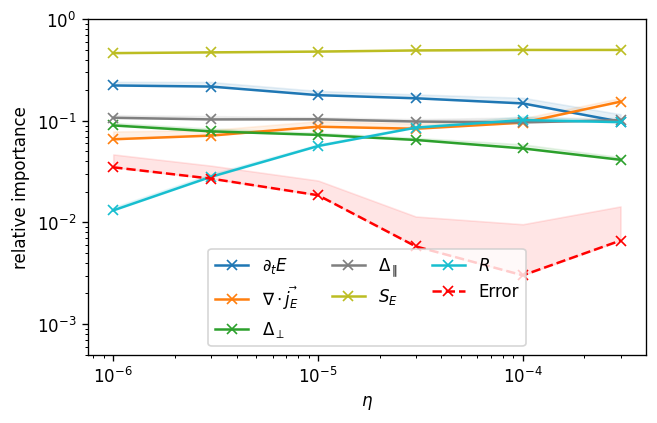

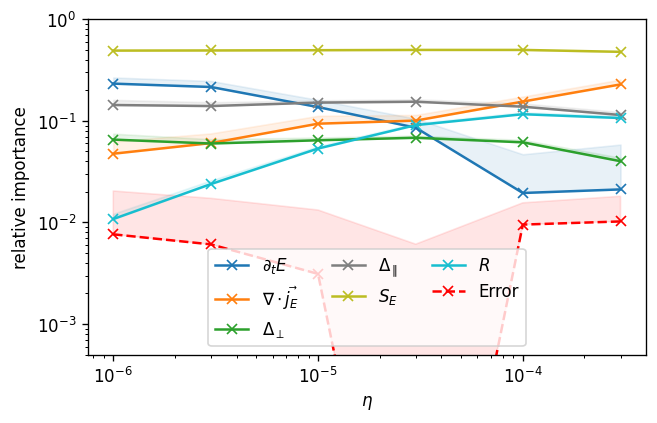

In [20]:
for tau in [0,1]:
    fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
    plot_relative(to_plot_energy,ax,tau,'log')
#     ax.set_yscale("linear")
    plt.legend(ncol = 3, loc = 'lower center')
    plt.ylim([5e-4,1])
    plt.savefig( 'energy-importance-'+str(tau)+'.png',bbox_inches='tight')
    plt.show()

### Vorticity accuracy on LCFS

In [21]:
### THE TERMS IN THE VORTICITY CONSERVATION
# idx=167 #=lcfs
idx = 167
to_plot_vorticity = {
    "tau" : [0,1], # taus
    "res": {0:[],1:[]}, # resistivities for taus
    "times": {0:dict(),1:dict()},
    "params" : {0:dict(),1:dict()}, # a copy of all parameters
    "fields" : [ # list of dicts
    {
#         "names" : ['oexbe_fsa'], # bad for tau = 1
        "names" : ['oexbe_fsa','odiae_fsa'],
#     vorticity =np.asarray(da['oexbe_fsa'][:,:])
    # vorticity+=da['odiae_fsa'][:,:]
    # vorticity/=da['electrons_fsa'][:,:]
        "idx":idx, "derive" : True,"signs" : [+1,1],
        "color": 0,
        "label" : r"$\partial_t (\Omega_E + \Omega_D)$",
        "vals": {0:dict(),1:dict()},
    },
    {
#         "names" : ['jvoexbi_tt_ifs'],
        "names" : ['jvoexbe_tt_ifs'],
        "idx": idx,"derive" : False, "signs" : [+1],
        "color": 5,
        "label" : r"$\nabla\cdot\vec{j_\Omega,E}$",
        "vals": {0:dict(),1:dict()},
    },    
    {
#         "names" : ['jvoexbeUD_tt_ifs'], # bad for tau = 1
#         "names" : ['jvoexbiUD_tt_ifs'], # also quite bad
        "names" : ['jvodiaeUE_tt_ifs'],
#         "names" : ['jvodiaiUE_tt_ifs'], # above 10%
        "idx": idx,"derive" : False, "signs" : [+1],
        "color": 2,
        "label" : r"$\nabla\cdot\vec{ j_\Omega,D}$",
        "vals": {0:dict(),1:dict()},
    },  
    {
        "names" : ['jvoapar_tt_ifs'],
        "idx": idx,"derive" : False, "signs" : [+1],
        "color": 8,
        "label" : r"$Maxwell$",
        "vals": {0:dict(),1:dict()},
    },
#     {
# #         "names" : ['jvoexbApar_tt_ifs'],
#         "names" : ['jvodiaApar_tt_ifs'],
#         "idx": idx,"derive" : False, "signs" : [+1],
#         "color": 9,
#         "label" : r"$\nabla\cdot\vec{ j_{\Omega,D,A}}$",
#         "vals": {0:dict(),1:dict()},
#     },
#     {
#         "names" : ['loexbe_tt_fsa'],"idx":idx, "derive" : False, "sign" : -1,
#         "color": 1,
#         "label" :  r"$\Lambda$",
#         "vals": {0:dict(),1:dict()},
#     },
    {
        "names" : ['socurve_tt_fsa','socurvi_tt_fsa','socurvkappae_tt_fsa','socurvkappai_tt_fsa'],
#     # force2 = -da["curvne_tt_ifs"][:,:]/deltat[:,None]/dvdpsi[:]
        "idx":idx, "derive" : False, "signs" : [-1,-1,-1,-1],
        "color": 6,
        "label" :  r"$Force$",
        "vals": {0:dict(),1:dict()},
    }
#     {
#         "names" : [''], "derive" : False, "sign" : -1,
#     # source = da["sosne_tt_fsa"][:,:]/deltat[:,None]
#     # source+= da["sospi_tt_fsa"][:,:]/deltat[:,None]
#         "color": 7,
#         "label" :  r"$S_{E}$",
#         "vals": {0:dict(),1:dict()},
#     },
    ]
}
make_to_plot(to_plot_vorticity)


Mean error is  -2.931574526727224e-06  std error is  1.5193371909897455e-06


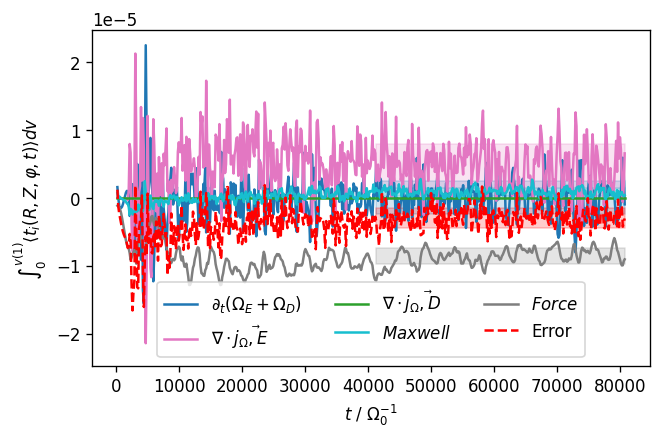

In [22]:
# for tau in [0,1]:
fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
tau = 0
res = 1e-5
plot_series(to_plot_vorticity,ax,tau,res)

plt.legend(ncol=3,loc='lower center')
plt.savefig( 'vor-conservation-lcfs-'+str(tau)+str(res)+'.png',bbox_inches='tight')
plt.show()

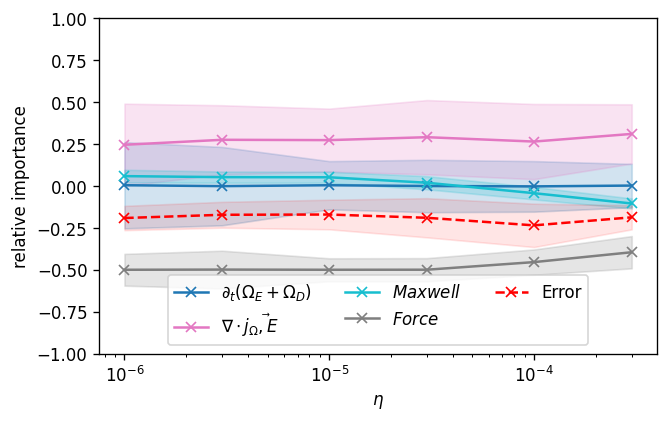

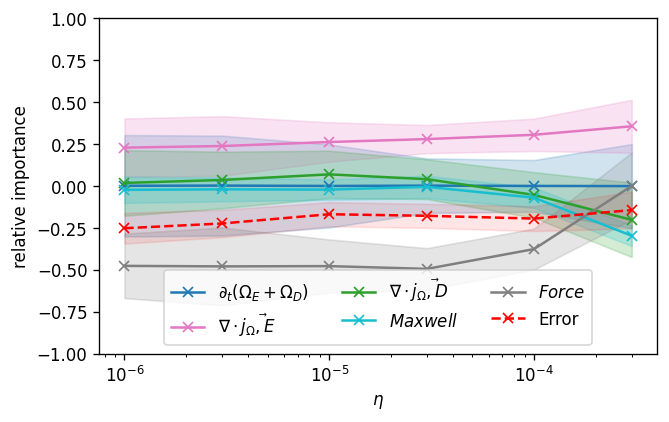

In [23]:
for tau in [0,1]:
    fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
    plot_relative(to_plot_vorticity,ax,tau,'linear')
#     ax.set_yscale("linear")
#     plt.legend()
    plt.legend( ncol=3, loc='lower center'#, bbox_to_anchor=(0.5, 1.05),
         )#, fancybox=True, shadow=True)
    ax.set_ylim([-1,1])
    plt.savefig( 'vor-importance-'+str(tau)+'.png',bbox_inches='tight')
    plt.show()

In [24]:
### THE TERMS IN THE VORTICITY/DENSITY DIFF CONSERVATION
to_plot_mass_diff = {
    "tau" : [0,1], # taus
    "res": {0:[],1:[]}, # resistivities for taus
    "times": {0:dict(),1:dict()},
    "params" : {0:dict(),1:dict()}, # a copy of all parameters
    "fields" : [ # list of dicts
    {
        "names" : ["electrons_ifs_lcfs","ions_ifs_lcfs"], "derive" : True, "signs" : [+1,-1],
        "color": 0,
        "label" : r"$\partial_t (n_e-N_i)$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['jvneE_tt_ifs_lcfs','jvniE_tt_ifs_lcfs'], "derive" : False, "signs" : [+1,-1],
        "color": 1,
        "label" : r"$\nabla\cdot\vec{ j_E}$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['jvneA_tt_ifs_lcfs','jvniA_tt_ifs_lcfs'], "derive" : False, "signs" : [+1,-1],
        "color": 8,
        "label" : r"$\nabla\cdot\vec{ j_A}$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['jvneC_tt_ifs_lcfs','jvniC_tt_ifs_lcfs'], "derive" : False, "signs" : [+1,-1],
        "color": 2,
        "label" : r"$\nabla\cdot\vec{ j_C}$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['divjnepar_tt_ifs_lcfs','divjnipar_tt_ifs_lcfs'], "derive" : False, "signs" : [+1,-1],
        "color": 3,
        "label" : r"$\nabla\cdot\vec{ j_\parallel}$",
        "vals": {0:dict(),1:dict()},
    },
#     { # 1e-6 for both 
#         "names" : ['sne_tt_ifs_lcfs','sni_tt_ifs_lcfs'], "derive" : False, "signs" : [-1,+1],
#         "color": 4,
#         "label" : r"$S$",
#         "vals": {0:dict(),1:dict()},
#     },
#     { # lniperp has a mistake
# #         "names" : ['lneperp_tt_ifs_lcfs','lniperp_tt_ifs_lcfs'], "derive" : False, "signs" : [-1,+1],
#         "names" : ['loexbe_tt_ifs_lcfs'], "derive" : False, "signs" : [-1],
#         "color": 5,
#         "label" : r"$\Delta_\perp$",
#         "vals": {0:dict(),1:dict()},
#     },
#     {
#         "names" : ['lneparallel_tt_ifs_lcfs','lniparallel_tt_ifs_lcfs'], "derive" : False, "signs" : [-1,+1],
#         "color": 6,
#         "label" : r"$\Delta_\parallel$",
#         "vals": {0:dict(),1:dict()},
#     },

    ]
}
make_to_plot(to_plot_mass_diff)


Mean error is  -212.98401390323727  std error is  58.509264262025894


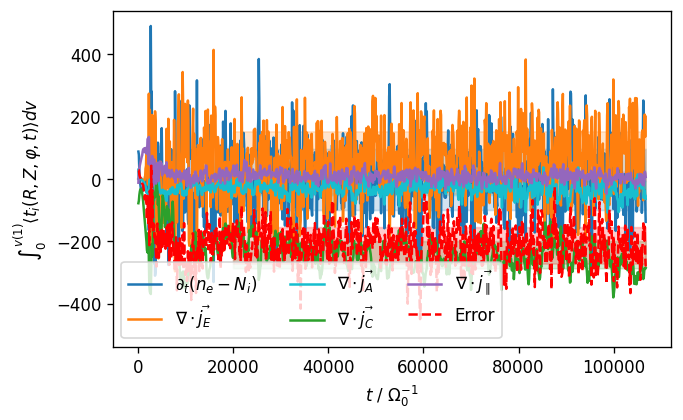

In [25]:
# for tau in [0,1]:
fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
tau = 0
res = 1e-4
plot_series(to_plot_mass_diff,ax,tau,res)

plt.legend(ncol=3,loc='lower left')
plt.savefig( 'neni-diff-conservation-lcfs-'+str(tau)+str(res)+'.png',bbox_inches='tight')
plt.show()

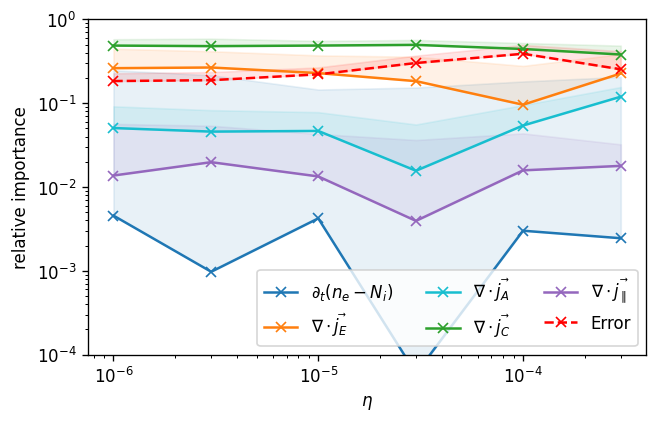

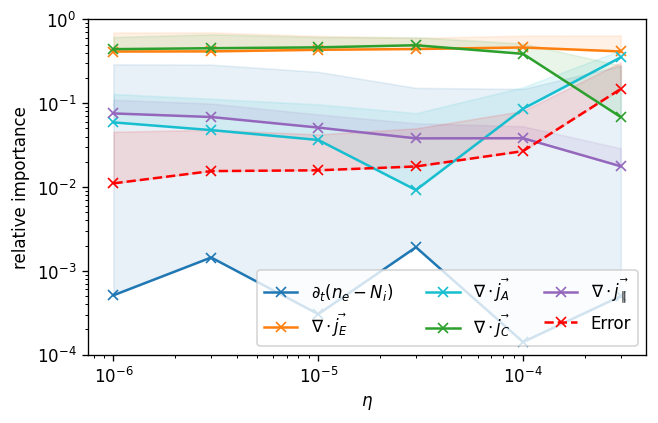

In [26]:
# more diffusion needed for tau=1 simulations?
# n_e - N_i not relevant for tau = 1 simulations?
for tau in [0,1]:
    fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
    plot_relative(to_plot_mass_diff,ax,tau,'log')
#     ax.set_yscale("linear")
    plt.legend(ncol=3,loc='lower right')
    plt.ylim([1e-4,1])
    plt.savefig( 'neni-diff-importance-'+str(tau)+'.png',bbox_inches='tight')
    plt.show()
    

## Ion parallel momentum

In [46]:
### THE TERMS IN THE TOROIDAL MOMENTUM
to_plot_momentum = {
    "tau" : [0,1], # taus
    "res": {0:[],1:[]}, # resistivities for taus
    "times": {0:dict(),1:dict()},
    "params" : {0:dict(),1:dict()}, # a copy of all parameters
    "fields" : [ # list of dicts
    {
        "names" : ["niui_ifs_lcfs"], "derive" : True, "signs" : [+1],
        "color": 0,
        "label" : r"$\partial_t N_iU_{\parallel,i}$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['jvparexbi_tt_ifs_lcfs'],
        "derive" : False, "signs" : [1],
        "color": 1,
        "label" : r"$\nabla\cdot(\vec{j_E})$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['jvparApar_tt_ifs_lcfs'],
        "derive" : False, "signs" : [1],
        "color": 2,
        "label" : r"$\nabla\cdot(\vec{j_A})$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['jvpardiai_tt_ifs_lcfs'],
        "derive" : False, "signs" : [1],
        "color": 3,
        "label" : r"$\nabla\cdot(\vec{j_D})$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['jvparkappai_tt_ifs_lcfs'],
        "derive" : False, "signs" : [1],
        "color": 4,
        "label" : r"$\nabla\cdot(\vec{j_K})$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ["sparmirrore_tt_ifs_lcfs","sparmirrori_tt_ifs_lcfs"],
        "derive" : False, "signs" : [-1,-1],
        "color": 5,
        "label" : r"$Mirror$",
        "vals": {0:dict(),1:dict()},
    },
#     divjpar = np.asarray(da['divjpare_tt_ifs_lcfs'][:])/deltat
#     divjpar += np.asarray(da['divjpari_tt_ifs_lcfs'][:])/deltat
#     { # is zero
#         "names" : ['sparsni_tt_ifs_lcfs'], "derive" : False, "signs" : [-1],
#         "color": 4,
#         "label" : r"$S$",
#         "vals": {0:dict(),1:dict()},
#     },
#     {
#         "names" : ['sparmirrorAe_tt_ifs_lcfs'], "derive" : False, "signs" : [-2],
#         "color": 7,
#         "label" : r"$Mirror_A$",
#         "vals": {0:dict(),1:dict()},
#     },
    ]
}
make_to_plot(to_plot_momentum)


Mean error is  -3184.662949964076  std error is  336.4487823523562


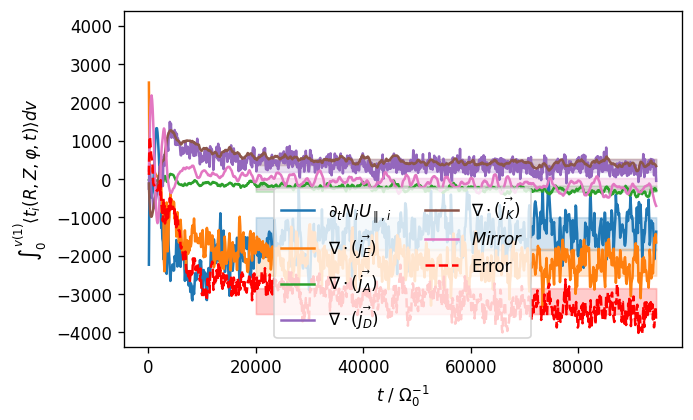

In [47]:
# for tau in [0,1]:
fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
tau = 1
res = 1e-4
if tau == 0:
    to_plot_momentum["fields"][-1]["signs"] = [-1]
if tau == 1:
    to_plot_momentum["fields"][-1]["signs"] = [-2]
plot_series(to_plot_momentum,ax,tau,res)

plt.legend(ncol = 2, loc = 'lower center')
plt.savefig( 'niui-conservation-lcfs-'+str(tau)+str(res)+'.png',bbox_inches='tight')
plt.show()

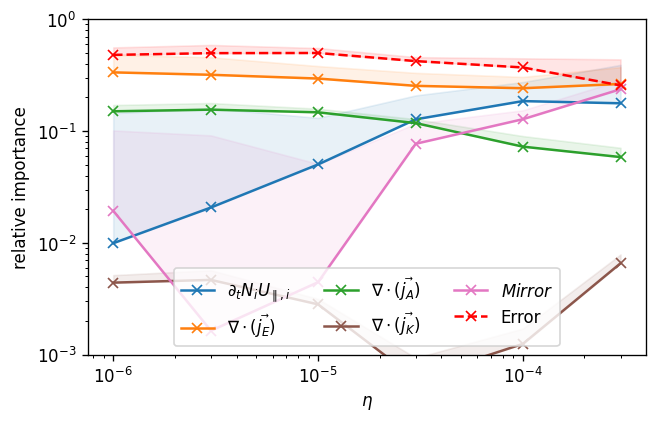

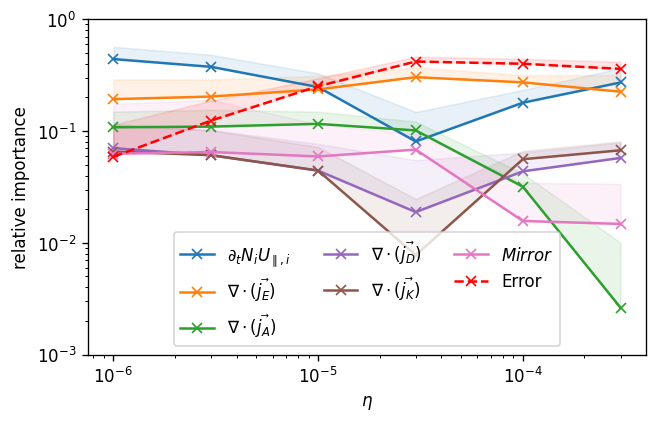

In [48]:
for tau in [0,1]:
    fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
    
#     if tau == 0:
#         to_plot_momentum["fields"][-1]["signs"] = [-1]
#     if tau == 1:
#         to_plot_momentum["fields"][-1]["signs"] = [-2]
    plot_relative(to_plot_momentum,ax,tau,'log')
#     ax.set_yscale("linear")
    plt.legend(ncol = 3, loc = 'lower center')
    plt.ylim([1e-3,1])
    plt.savefig( 'niui-importance-'+str(tau)+'.png',bbox_inches='tight')
    plt.show()

## Parallel electron force balance

In [49]:
### THE TERMS IN THE PARALLEL ELECTRON FORCE BALANCE
to_plot_electron_force = {
    "tau" : [0,1], # taus
    "res": {0:[],1:[]}, # resistivities for taus
    "times": {0:dict(),1:dict()},
    "params" : {0:dict(),1:dict()}, # a copy of all parameters
    "fields" : [ # list of dicts
    {
        "names" : ['sparmirrore_tt_ifs_lcfs'],
        "derive" : False, "signs" : [1],
        "color": 5,
        "label" : r"$Mirror$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['friction_tt_ifs_lcfs'],
        "derive" : False, "signs" : [1],
        "color": 2,
        "label" : r"$\eta$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['sparphie_tt_ifs_lcfs'],
        "derive" : False, "signs" : [1],
        "color": 3,
        "label" : r"$n_e\nabla_\parallel\phi$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['sparphiAe_tt_ifs_lcfs'],
        "derive" : False, "signs" : [1],
        "color": 4,
        "label" : r"$n_e\nabla_{A,\parallel}\phi$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['spardotAe_tt_ifs_lcfs'],
        "derive" : False, "signs" : [1],
        "color": 8,
        "label" : r"$n_e\partial_t A_\parallel$",
        "vals": {0:dict(),1:dict()},
    },
#     { # it works better without ...
#         "names" : ['sparmirrorAe_tt_ifs_lcfs'], "derive" : False, "signs" : [+1],
#         "color": 7,
#         "label" : r"$Mirror_A$",
#         "vals": {0:dict(),1:dict()},
#     },
    ]
}
make_to_plot(to_plot_electron_force)


Mean error is  -37.39187246168291  std error is  29.775239435441467


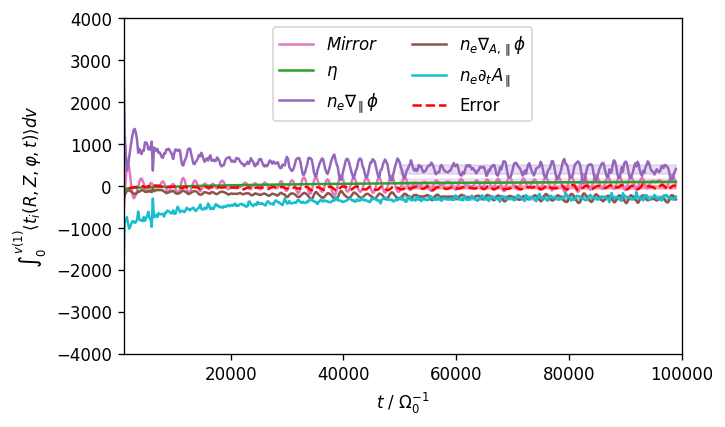

In [50]:
# for tau in [0,1]:
fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
tau = 1
res = 1e-6
plot_series(to_plot_electron_force,ax,tau,res)
low, high = ax.get_ylim()
bound = 4000# max(abs(low), abs(high))
ax.set_ylim(-bound, bound)
ax.set_xlim(1000,100000)
plt.legend(ncol = 2, loc='upper center')
plt.savefig( 'ue-conservation-lcfs-'+str(tau)+str(res)+'.png',bbox_inches='tight')
plt.show()

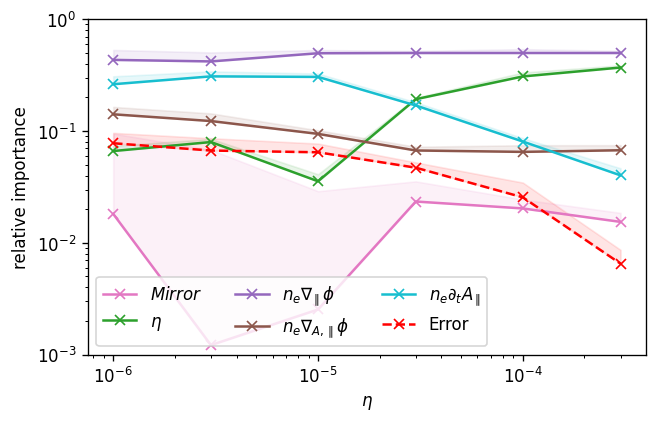

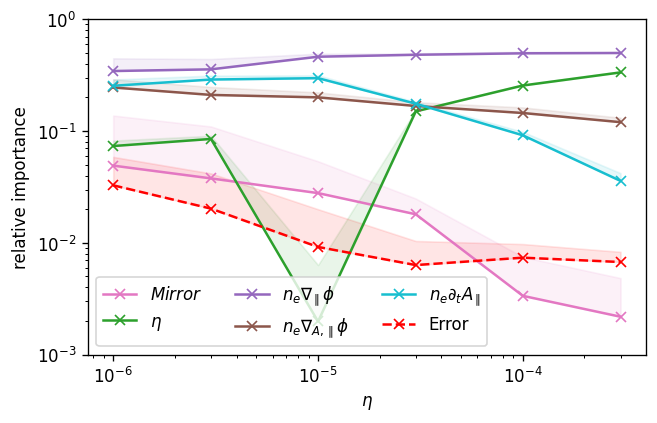

In [51]:
for tau in [0,1]:
    fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
    
    if tau == 0:
        to_plot_momentum["fields"][-1]["signs"] = [-1]
    if tau == 1:
        to_plot_momentum["fields"][-1]["signs"] = [-2]
    plot_relative(to_plot_electron_force,ax,tau,'log')
#     ax.set_yscale("linear")
    plt.legend(ncol=3, loc = 'lower left')
    plt.ylim([1e-3,1])
    plt.savefig( 'ue-importance-'+str(tau)+'.png',bbox_inches='tight')
    plt.show()